Importing Dependencies
- Pytorch: The neural network framework that will be used today
- MatPlotLib: Used to graph a few examples


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.optim import Adam
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

Load datasets from torchvision 

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor())
type(train_data)

torchvision.datasets.mnist.FashionMNIST

Visualizing the Dataset:

There are 60000 training examples and 10000 test examples.


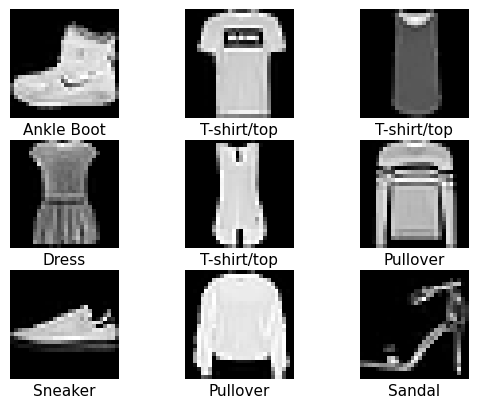

In [4]:
print(f'There are {len(train_data)} training examples and {len(test_data)} test examples.')
# create a dictionary associating the true labels of X from one hot to english
label_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}

# display first 9 examples 
for i,(image,label) in enumerate(train_data):
    if i == 9:
        break
    else:

        image, label = train_data[i]
        image = TF.to_pil_image(image)
        image = image.convert('L')
        plt.subplot(3,3,i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.text(0.5, -0.15, label_dict[label], fontsize=11, ha='center', transform=plt.gca().transAxes)
        
plt.show()

Convert data into PyTorch DataLoader objects
Using mini-batch descent of size 10

In [5]:
train_set = DataLoader(train_data, batch_size=10, shuffle=True)
test_set = DataLoader(test_data, batch_size=10000, shuffle=False)

- Now, configuring the architecture of our neural network.
- Use convolutional with kernel size of 3 to act as feature detector
- Dropout regularization on the linear layers
- Pooling layer to reduce complexity of convolutional layers
- Log Softmax for cross entropy loss
- Returns output tensor of shape [num_examples x 10] with the greatest value in each row being the predicted label

In [11]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)

        self.conv2 = nn.Conv2d(16, 32, 3)
        self.linear_1 = nn.Linear(4608, 64)
        self.linear_2 = nn.Linear(64, 10)

        
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.33)

    def forward(self, X):
        x = self.conv1(X)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = self.linear_1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.linear_2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        output = F.log_softmax(x, dim=1)

        return output


Initialize the model
Set the loss function -> Cross Entropy Loss for multi-class classification

In [12]:
model = Net()
loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 4


- Function to test model on the test set
- Set model mode to evaluation to remove dropout
- Returns cost and true accuracy

In [13]:
def test_model(set):
    model.eval()
    total = 0.0
    correct = 0.0
    
    with torch.no_grad():
        for data, target in set:
            y_pred = model(data)
            _, predicted = torch.max(y_pred, 1)
            cost = loss(y_pred , target)
            total += target.size(0)
            correct += (predicted ==target).sum().item()

    accuracy = round(correct / total * 100, 2)

    return cost , accuracy

Training for loop:
 - iterates through epochs
    - then iterates through batches
    - Runs forward and backward propagation
    - Clears gradients stored with the data
Prints test cost and accuracy after each epoch
Prints training cost and accuracy after each epoch (checking for overfitting)


In [14]:

for i in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_set):

        y_pred = model(data)

        cost = loss(y_pred , target)

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()


    test_cost , accuracy = test_model(train_set)
    train_cost , train_accuracy = test_model(test_set)
    print(f'{int((i+1)*25)}% done -- Test Cost: {round(float(test_cost),5)} -- Test Accuracy: {accuracy}% -- Train Accuracy: {train_accuracy}%')
    


25% done -- Test Cost: 0.40998 -- Test Accuracy: 88.23% -- Train Accuracy: 87.34%
50% done -- Test Cost: 0.37092 -- Test Accuracy: 89.61% -- Train Accuracy: 88.26%
75% done -- Test Cost: 0.29072 -- Test Accuracy: 90.64% -- Train Accuracy: 89.11%
100% done -- Test Cost: 0.52508 -- Test Accuracy: 91.9% -- Train Accuracy: 90.29%
